### PIPELINE OVERVIEW

----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE
----------

In [131]:
from multidimvis_main import *

_____
# 1 | SELECT ONE NETWORK GRAPH
_____

In [3]:
################################################
#
# Y E A S T 
#
################################################

organism = 'Yeast'

data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)
G = G_cere

posG_entrez = []
for k in G.nodes():
    posG_entrez.append(k[22:])
    
df_gID_sym = pd.read_csv('input/Yeast_geneID_sym.csv', index_col=0)
gene_sym = list(df_gID_sym['Sym'])
gene_id = list(df_gID_sym.index)
g_ID_sym = dict(list(zip(gene_id, gene_sym)))
#len(g_ID_sym)
    
l_features = []
for i in g_ID_sym.values():
    l_features.append(i)
    
# ESSENTIALITY 

cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
 
cere_sym = list(cere_gene['symbols'])
cere_ess = list(cere_gene['essentiality status'])
cere_sym_essentiality = dict(zip(cere_sym, cere_ess))

d_cere_ess = {}
d_cere_noess = {}
d_cere_unknown = {}

for node,es in cere_sym_essentiality.items():
    if es == 'E':
        d_cere_ess[node]=es
    elif es == 'NE':
        d_cere_noess[node]=es
        
d_cere_alless = {}
for nid, sym in g_ID_sym.items():
    for sy,ess in cere_sym_essentiality.items():
        if sym == sy:
            d_cere_alless[nid] = ess
            
d_cere_unknown = {} 
for g in G.nodes():
    if g not in d_cere_alless.keys():
        d_cere_unknown[g]='status unkonwn'
    
d_geneID_ess = {**d_cere_unknown, **d_cere_alless}

d_gID_ess = {}
d_gID_noess = {}
d_gID_notdef = {}

for k,i in d_geneID_ess.items():
    if i == 'E':
        d_gID_ess[k] = i
    elif i == 'NE':
        d_gID_noess[k] = e
    else: 
        d_gID_notdef[k] = 'not defined'

d_gID_all_unsorted = {**d_gID_ess, **d_gID_noess, **d_gID_notdef}
d_gID_all = {key:d_gID_all_unsorted[key] for key in G.nodes()}


# Centrality features 
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

In [2]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}

#df_gene_sym = pd.read_csv('_output_csv/DF_gene_symbol_Human.csv', index_col=0)
#l_features = list((df_gene_sym.to_dict()).values())

posG_entrez = []
for k in G.nodes():
    posG_entrez.append(k)
    
# Gene Symbols 
df_gene_sym = pd.read_csv('_output_csv/DF_gene_symbol_Human.csv', index_col=0)
l_features = list(df_gene_sym['0'])


# ESSENTIALITY 
# get dataframe with ENSG-ID and essentiality state 
df_human_ess = pd.read_table('input/human_essentiality.txt', delim_whitespace=True)

# create dict with ENSG-ID:essentiality state 
ensg_id = list(set(df_human_ess['sciName']))
gene_ess = list(df_human_ess['locus'])
d_ensg_ess = dict(zip(ensg_id, gene_ess))
 
# match ENSG-ID with entrezID
# "engs_to_entrezid": entrezIDs were matched with "ensg_id.txt" via "DAVID Database" (https://david.ncifcrf.gov/conversion.jsp)
df_human_ensg_entrez = pd.read_table('input/ensg_to_entrezid.txt')# delim_whitespace=False)
df_human_ensg_entrez.dropna()

df = df_human_ensg_entrez
df['To'] = df['To'].fillna(0)
df['To'] = df['To'].astype(int)
df_human_ensg_entrez = df

# create dict with ENGS-ID: entrezID
ensgid = list(df_human_ensg_entrez['From']) #engs ID
entrezid = list(df_human_ensg_entrez['To']) #entrez ID 

# dict with engsid : entrezid
d_ensg_entrez = dict(zip(ensgid, entrezid))

# create dict with entrezID:essentiality state 
d_id_ess_unsorted = {}
for ens,ent in d_ensg_entrez.items():
    for en, ess in d_ensg_ess.items():
        if ens == en:
            d_id_ess_unsorted[str(ent)] = ess
            
            
# check if G.nodes match entrezID in dict and sort according to G.nodes 
d_gid_ess = {}
for k,v in d_id_ess_unsorted.items():
    if k in G.nodes():
        d_gid_ess[k]=v
        
# create dict with rest of G.nodes not in dict (entrezID:essentiality)
d_gid_rest = {}
for g in G.nodes():
    if g not in d_gid_ess.keys():
        d_gid_rest[g]='not defined'
        
#print(len(d_gid_rest)+len(d_gid_ess)) # this should match G.nodes count 

# merge both dicts
d_gid_ess_all_unsorted = {**d_gid_ess, **d_gid_rest}

# sort -> G.nodes()
d_gID_all = {key:d_gid_ess_all_unsorted[key] for key in G.nodes()}


# Centrality features 
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

In [3]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s'%len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 16376
Number of edges: 309355
Network density: 0.2%


_____
# 2 | LOAD AND SELECT ONF OF THE FOLLOWING FEATURES
_____

+ select one of the following
_____

### + STRUCTURAL : Graph structure based


In [ ]:
feature = 'adj'

DM_adj = pd.read_csv('_output_csv/Adjacency_Dataframe_'+organism+'.csv', index_col=0)
DM_adj.index = list(G.nodes())
DM_adj.columns = list(G.nodes())

DM = DM_adj

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [7]:
feature = 'rwr_vis'

DM_m_visprob = pd.read_csv('_output_csv/RWR_visitingprob_Dataframe_'+organism+'.csv', index_col=0)
DM_m_visprob.index = list(G.nodes())
DM_m_visprob.columns = list(G.nodes())

DM = DM_m_visprob

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [ ]:
feature = 'rwr_dist'

DM_m = pd.read_csv('_output_csv/RWR_Dataframe_'+organism+'.csv', index_col=0)
DM_m.index = list(G.nodes())
DM_m.columns = list(G.nodes())

DM = DM_m

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [ ]:
feature = 'cent'

DM_centralities = pd.DataFrame(distance.squareform(distance.pdist(df_centralities, 'cosine')))

DM_centralities = round(DM_centralities,4)
DM_centralities.index = list(G.nodes())
DM_centralities.columns = list(G.nodes())

DM = DM_centralities

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

### + FUNCTIONAL : Molecular Function

#### GO : Molecular Function 

In [ ]:
feature = 'molfunc'

# Feature Matrix loaded 
Feature_MF = pd.read_csv('_output_csv/Features_GO_MolFunc_Dataframe_Human.csv', index_col=0)

# Distance Matrix loaded
DM_MF = pd.read_csv('_output_csv/DistanceMatrix_goMF_Dataframe_Human_cosine.csv', index_col=0)

DM_MF_mod = DM_MF.round(decimals=4)
DM_MF = DM_MF_mod
DM = DM_MF

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

#### GO : Cellular Component

In [ ]:
feature = 'cellcomp'

DM_CC = pd.read_csv('_output_csv/DistanceMatrix_goCC_Dataframe_Human_cosine.csv', index_col=0)

DM_CC_mod = DM_CC.round(decimals=4)
DM = DM_CC_mod

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

#### GO : Biological Processes

In [ ]:
feature = 'bioproc'

DM_BP = pd.read_csv('_output_csv/DistanceMatrix_goBP_Dataframe_Human_cosine.csv', index_col=0)
    
DM_BP_mod = DM_BP.round(decimals=4)
DM = DM_BP_mod

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

#### Disease Annotations

In [ ]:
feature = 'disease'

DM_Disease = pd.read_csv('_output_csv/DistanceMatrix_Disease_Dataframe_Human_cosine.csv', index_col=0)
    
DM_Disease_mod = DM_Disease.round(decimals=4)
DM = DM_Disease_mod

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if i in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

____________
# 3 | SET VISUAL PRE-SETTINGS
____________

## GENERAL NODE + EDGE PARAMETERS

In [8]:
# Node, Edge colors

edge_width = 0.1
edge_colorlight = '#d3d3d3' # 'lightgrey'
edge_colordark = '#696969' # 'dimgrey'
opacity_edges = 0.5
opacity_nodes = 1.0
node_edge_col = None

# Node sizes 

scalef= 0.5
size = list(draw_node_degree(G, scalef).values())

scalef= 0.05
size3d = list(draw_node_degree_3D(G, scalef).values())

## NODE COLOR SETTINGS 
+ choose one of the following

#### ------ STRUCTURAL ------ 

In [16]:
# ------------------
# FROM DICTIONARY (geneID:value)
# ------------------
color_method = 'clos'
d_colours = color_nodes_from_dict(G, d_clos, color_method, palette = 'YlOrRd')
colours = list(d_colours.values())

#### ------ ESSENTIALITY ------ 

In [774]:
# colours based on essentiality state 
color_method = 'essent'
d_colours = color_nodes_from_dict(G, d_gID_all, color_method, palette = 'ocean')
colours = list(d_colours.values())

#### ------ SPECIFIC DISEASES ------ 

In [299]:
# ----------------------------------------------------        
# get disease categories
# ----------------------------------------------------        
disease_categories = {}
for d_name in d_names_do.keys():
    #if d_name.find(disease_category) != -1:
        try:
            disease_categories[d_name,d_names_do[d_name]]=len(d_do_genes[d_names_do[d_name]])
            #print('specific disease: %s (%s) ; # associated genes: %s' %(d_name,d_names_do[d_name],len(d_do_genes[d_names_do[d_name]])))
        except:
            pass

# ----------------------------------------------------        
# search specific term + count of genes associated with disease 
# ----------------------------------------------------   
min_diseasegenes = 2000
max_diseasegenes = 3000
search_term = 'cancer'

for k,v in disease_categories.items():
    if v >= min_diseasegenes and v<= max_diseasegenes and search_term in k[0]:
        print(k,v)

('organ system cancer', 'DOID:0050686') 2386
('cancer', 'DOID:162') 2497


In [300]:
disease_category = 'cancer'
disease_col = '#FF0000' #'red'

color_method = disease_category

l_genes = get_disease_genes(G, d_names_do, d_do_genes, disease_category)
#colours = color_diseasecategory(G, d_names_do, d_do_genes, disease_category, disease_col)
colours = color_nodes_from_genelist(G, l_genes, disease_col)

# color edges based on gene list of selection 
d_edge_col = color_edges_from_genelist(G, l_genes, disease_col)
edge_color = list(d_edge_col.values())

#### ------ SPECIFIC GO TERM ------  

In [117]:
# ----------------------------------------------------        
# search specific term + count of genes associated with GO term
# ----------------------------------------------------   
min_genes = 0 
max_genes = 500
min_dens = 0.5

for g,n in d_goid_genes.items():
    G_sub = G.subgraph(n)
    dens = nx.density(G_sub)
    if dens >= min_dens and len(n) >= min_genes and len(n) <= max_genes:
            print('GO-term:',g, '| Number of genes:',len(n), '| Density: ', round(dens,2),'%')

GO-term: GO:0003954 | Number of genes: 36 | Density:  0.52 %
GO-term: GO:0008137 | Number of genes: 36 | Density:  0.52 %
GO-term: GO:0050136 | Number of genes: 36 | Density:  0.52 %


In [124]:
# Choose a GO term here: 
goterm = 'GO:0050136'

l_genes = d_goid_genes[goterm]
go_col = 'blue'

colours = color_nodes_from_genelist(G, l_genes, go_col)
d_edge_col = color_edges_from_genelist(G, l_genes, go_col)
edge_color = list(d_edge_col.values())


# in progress 
'''# ----------------------------------------------------        
# ANY GENE LIST
# ----------------------------------------------------  
     
color_method = 'my gene list' 
color = '#0000FF' #'blue'

# n o d e s 
l_genes = # HERE GOES my list of gene identifiers
colours = color_nodes_from_genelist(G, l_genes, color)

# e d g e s 
edge_color = list(color_edges_from_genelist(G, l_genes, color).values())'''

____________
# 4 | LAYOUTS
____________

___
## 2D PORTRAITS
___

## UMAP
+ https://umap-learn.readthedocs.io/en/latest/embedding_space.html

+ https://pair-code.github.io/understanding-umap/

In [19]:
%%time 

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.05 # defines how dense points are stacked together 
metric ='cosine'

umap2D = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 3min 44s, sys: 6.16 s, total: 3min 50s
Wall time: 1min 28s


In [20]:
# MAIN (if not all G.nodes)
posG_umap = get_posG_2D(genes, umap2D)

# REST (if main = G.nodes then rest will be ignored / empty)
# generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
t = np.random.uniform(0,2*np.pi,len(genes_rest))

# get center of points and define radius
xx=[]
yy=[]
for i in posG_umap.values():
    xx.append(i[0])
    yy.append(i[1])

cx = sum(xx)/len(genes)
cy = sum(yy)/len(genes)

xm, ym = max(posG_umap.values())
r = (math.sqrt((xm-cx)**2 + (ym-cy)**2))+10 #*1.05 # multiplying with 1.05 makes cirle larger to avoid "outsider nodes/genes"

x = r*np.cos(t)
y = r*np.sin(t)

rest = []
for i,j in zip(x,y):
        rest.append((i,j))
        
posG_rest = dict(zip(genes_rest, rest))

posG_all = {**posG_umap, **posG_rest}
posG_complete_umap= {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
for k,v in posG_complete_umap.items():
    x_list.append(v[0])
    y_list.append(v[1])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)


posG_complete_umap_norm = dict(zip(list(G.nodes()),zip(xx_norm,yy_norm)))

### UMAP CLUSTER Colors (spectral) > supervised > cluster number assigned

In [285]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_complete_umap_norm).T #posG_umap

n_clus = 30
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 10, affinity='nearest_neighbors',random_state=0)
clusterid = model.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = model.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'hsv') #'ocean'

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



### UMAP CLUSTER Colors (DBSCAN) > unsupervised > density and radius assigned
+ https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d

In [255]:
from sklearn.cluster import DBSCAN

color_method = 'dbscan'
df_posG = pd.DataFrame(posG_complete_umap_norm).T #posG_umap

# eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
# MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
clustering = DBSCAN(eps=0.01, min_samples=1) 

clusterid = clustering.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = clustering.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'PiYGhsv')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

print('Number of Clusters: ', len(set(clusterid.labels_)))

Number of Clusters:  265


Color method:  clos


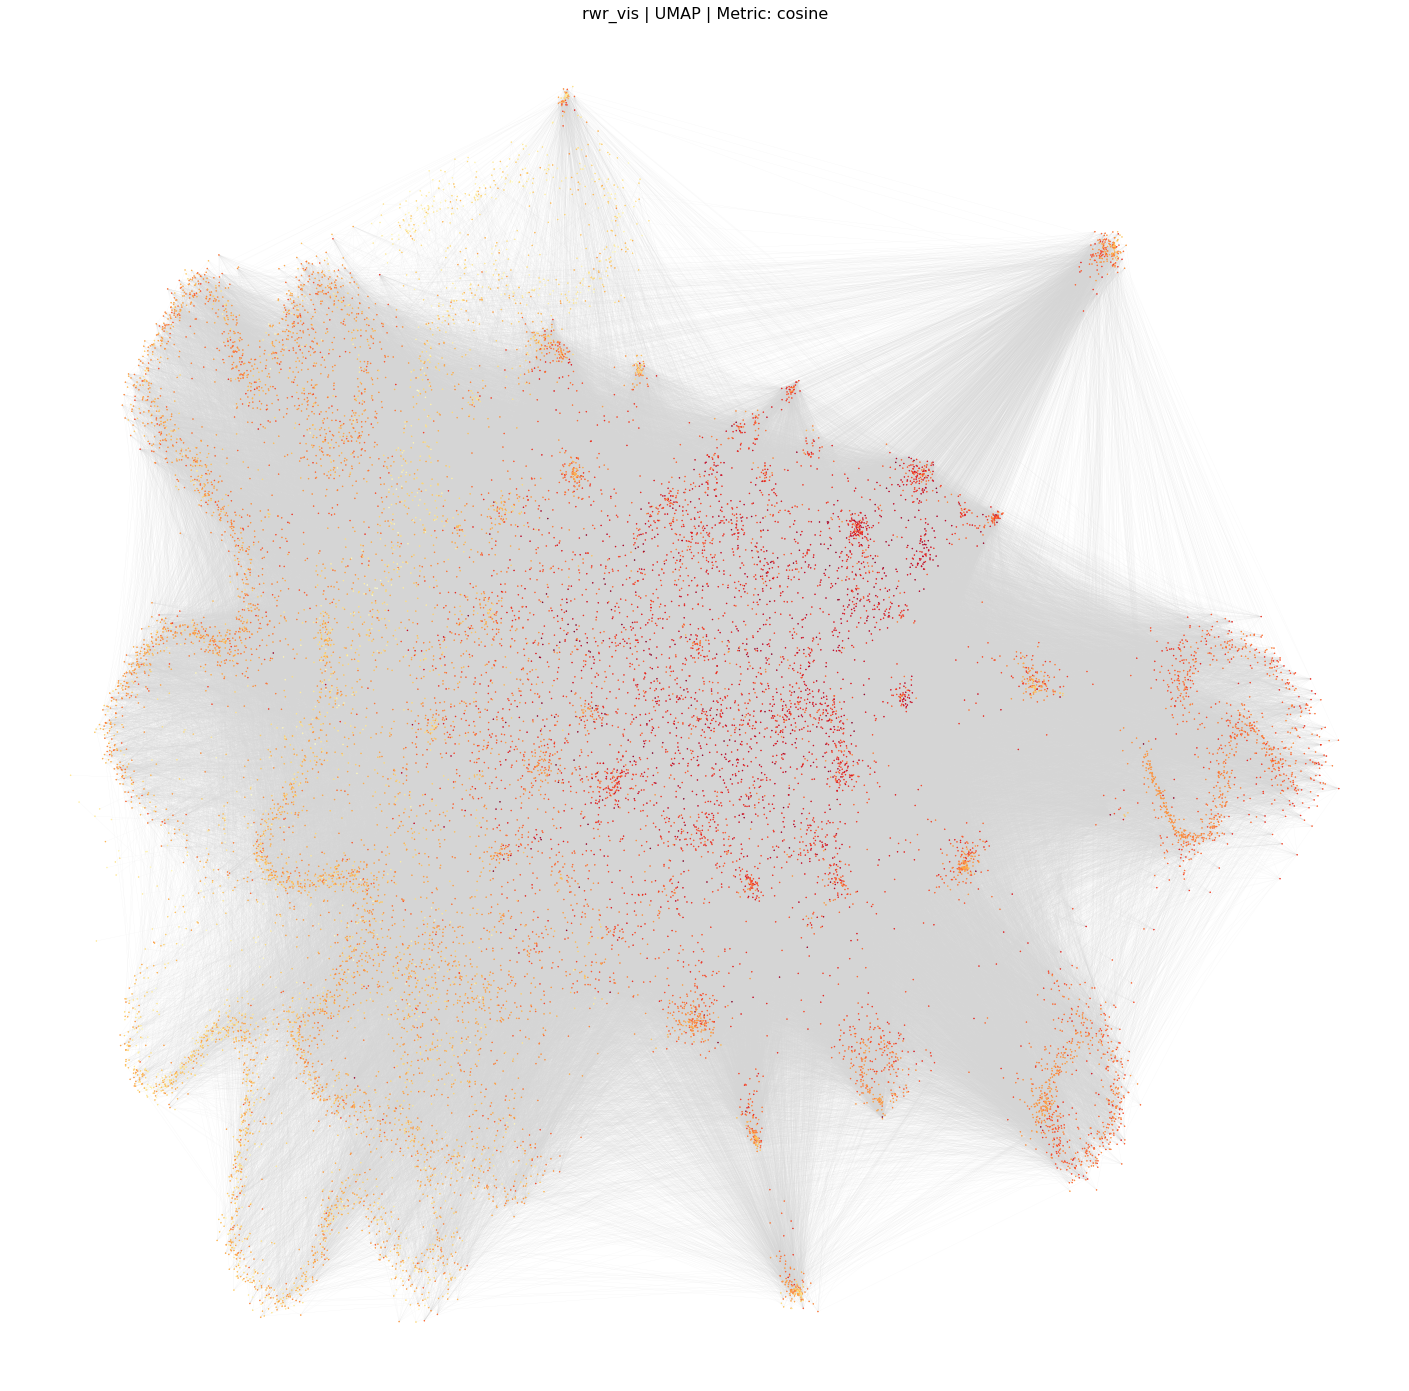

In [81]:
print('Color method: ', color_method)

plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_norm, 
                       edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 1.0,#size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_norm,
                       width = edge_width, edge_color = edge_colorlight, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2DPortraitumap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_.png')

plt.show()

#### UMAP EXPORT TO CSV

In [79]:
export_to_csv2D('C_2Dportrait', posG_complete_umap_norm, colours)

___
## LANDSCAPES
___

### Define z-parameter
+ Choose one of the following
___________

#### ------ STRUCTURAL ------

In [227]:
# dict with geneID : value 
# e.g. Closeness centrality

z_feat = 'clos'

z_list = list(d_clos.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1.0), axis=0, copy=True)

#### ------ Centrality Metrics average ------

In [429]:
z_feat = 'centraverage'

d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[i] = round((j[0]+j[1]+j[2]+j[3])/4,4)
    
'''d_binned = bin_nodes(d_centr)

d_node_bin = {}
for k,v in d_binned.items():
    for each in v:
        d_node_bin[each] = k
        
dict_z = {key:d_node_bin[key] for key in G.nodes()}'''

dict_z  = {key:d_centr[key] for key in G.nodes()}


z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1.0), axis=0, copy=True)

#### ------ Disease count ------

In [82]:
z_feat = 'disease'

#DM_feature = DM_Disease
feat_matrix = pd.read_csv('_output_csv/Features_Disease_Dataframe_Human.csv', index_col=0)
DM_feature = feat_matrix

# set gene list (= G.nodes())
genes_assoc = []
for i in DM_feature.index:
    genes_assoc.append(str(i))
    
genes_notassoc = [] 
for g in G.nodes():
    if g not in genes_assoc:
        genes_notassoc.append(g)

features_counted = (feat_matrix == 1).astype(int).sum(axis=1)
d_features_counted = dict(zip(genes_assoc, list(features_counted)))
        
d_rest = {}
for i in genes_notassoc: 
    d_rest[i] = -20

d_param_unsorted = {**d_features_counted, **d_rest}
dict_z = {key:d_param_unsorted[key] for key in G.nodes()}

z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

________

## UMAP

In [83]:
posG_land_umap = {}
cc = 0
for k,v in posG_complete_umap_norm.items():
    posG_land_umap[k] = (v[0],v[1],z_list_norm[cc])
    cc+=1

In [84]:
umap_nodes = get_trace_nodes_3D(posG_land_umap, l_features, colours, 1.0) #size3d)

# all edges visible
umap_edges = get_trace_edges_3D(G, posG_land_umap, edge_colorlight)

# specific edges only visible
#umap_edges = get_trace_spec_edges_only(list(d_edge_col.keys()), posG_land_umap, disease_col)#go_col)

#umap_data = [umap_edges, umap_nodes]
umap_data = [umap_nodes]

In [85]:
print('# Neighbors: ', n_neighbors)
print('Spread: ', spread)
print('Min. Distance: ', min_dist)
print('Metric: ', metric)

data = umap_data
scheme = 'light'
fname = 'output_plots/Landscapes_umap_'+feature+'_'+color_method+'_z-'+z_feat+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism

plot_3D(data, fname, scheme)

# Neighbors:  10
Spread:  1.0
Min. Distance:  0.01
Metric:  cosine


'output_plots/Landscapes_umap_rwr_vis_clos_z-disease_cosine_clos_10_1.0_0.01_Human.html'

#### UMAP LANDSCAPE EXPORT TO CSV

In [28]:
export_to_csv3D('C_Landscape', posG_land_umap, colours)

____
## 3D PORTRAITS
____

## UMAP

In [30]:
%%time 

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.01 # defines how dense points are stacked together 
metric='cosine'

umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 5min 26s, sys: 7.77 s, total: 5min 34s
Wall time: 1min 17s


In [87]:
# MAIN (if not all G.nodes)
posG_3Dumap = get_posG_3D(genes, umap_3D)

# REST (if genes = G.nodes then rest will be ignored / empty)

# get center of data points
xx=[]
yy=[]
zz=[]

for i in posG_3Dumap.values():
    xx.append(i[0])
    yy.append(i[1])
    zz.append(i[2]) 

cx = sum(xx)/len(genes)
cy = sum(yy)/len(genes)
cz = sum(zz)/len(genes)

# generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
indices = arange(0, len(genes_rest))
phi = arccos(1 - 2*indices/len(genes_rest)) # 2* --> for both halfs of sphere (upper+lower)
theta = pi * (1 + 5**0.5) * indices

xm, ym, zm = max(posG_3Dumap.values())
r = (math.sqrt((cx - xm)**2 + (cy - ym)**2 + (cz - zm)**2))+1 # +10 to ensure all colored nodes are within the sphere
x, y, z = cx+r*cos(theta) * sin(phi),cy+r*sin(theta) * sin(phi), cz+r*cos(phi)

rest_points = []
for i,j,k in zip(x,y,z):
    rest_points.append((i,j,k))

posG_rest = dict(zip(genes_rest, rest_points))

posG_all = {**posG_3Dumap, **posG_rest}
posG_3D_complete_umap = {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_3D_complete_umap.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

posG_3D_complete_umap_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))

In [126]:
# delete  this cell  if cluster annotationsw work 

x=[]
y=[]
z=[]
for i in posG_3D_complete_umap_norm.values():
    x.append(i[0])
    y.append(i[1])
    z.append(i[2])

centroid = (sum(x) / len(posG_3D_complete_umap_norm.values()), sum(y) / len(posG_3D_complete_umap_norm.values()),  sum(z) / len(posG_3D_complete_umap_norm.values()))


annotations_darkmode = [dict(
                x=centroid[0],
                y=centroid[1],
                z=centroid[2],
                showarrow=True,
                text='some text here',
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                )]

annotations_lightmode = [dict(
                x=centroid[0],
                y=centroid[1],
                z=centroid[2],
                showarrow=True,
                text='some text here',
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="dimgrey"
                )]

### UMAP CLUSTER Colors (Spectral)

In [271]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_3D_complete_umap_norm).T #posG_3Dumap

n_clus = 50
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 10, affinity='nearest_neighbors')
clusterid = model.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = model.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'prism')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



### UMAP CLUSTER Colors (DBSCAN)

In [103]:
from sklearn.cluster import DBSCAN

color_method = 'dbscan'
df_posG = pd.DataFrame(posG_3D_complete_umap_norm).T #posG_3Dumap

# eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
# MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
clustering = DBSCAN(eps=0.025, min_samples=1) 

clusterid = clustering.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = clustering.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'Set1')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

print('Number of clusters: ', len(set(clusterid.labels_)))

Number of clusters:  519


In [130]:
# compute cluster centers







AttributeError: 'DBSCAN' object has no attribute 'cluster_centers_'

In [ ]:
x=[]
y=[]
z=[]
for i in posG_3D_complete_umap_norm.values():
    x.append(i[0])
    y.append(i[1])
    z.append(i[2])

centroid = (sum(x) / len(posG_3D_complete_umap_norm.values()), sum(y) / len(posG_3D_complete_umap_norm.values()),  sum(z) / len(posG_3D_complete_umap_norm.values()))

In [ ]:
annotations_darkmode = [dict(
                x=centroid[0],
                y=centroid[1],
                z=centroid[2],
                showarrow=True,
                text='some text here',
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="white"
                )]

annotations_lightmode = [dict(
                x=centroid[0],
                y=centroid[1],
                z=centroid[2],
                showarrow=True,
                text='some text here',
                xanchor="right",
                ay=-100,
                ax=-100,
                opacity=0.8,
                arrowhead=0,
                arrowwidth=0.5,
                arrowcolor="dimgrey"
                )]

In [127]:
%%time 
umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, 1.0) #size3d)
umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap_norm, edge_colordark, opac=0.05)
#umap_edges = get_trace_spec_edges_only(list(d_edge_col.keys()), posG_3D_complete_umap_norm, disease_col)#go_col)

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

CPU times: user 4.54 s, sys: 83.5 ms, total: 4.63 s
Wall time: 4.64 s


In [129]:
print('Color method: ', color_method)

print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)

data = umap_data
scheme = 'dark'

if color_method == 'dbscan':
    fname = 'output_plots/3Dportrait_umap_'+feature+'_'+color_method+'_'+'numclusters'+str(len(set(clusterid.labels_)))+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism
else:
    fname = 'output_plots/3Dportrait_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism
    
plot_3D(data, fname, scheme, annotations_darkmode)

Color method:  dbscan
# Neighbours: 10
Spread: 1.0
Min. Distance: 0.01


'output_plots/3Dportrait_umap_rwr_vis_dbscan_numclusters519_10_1.0_0.01_Human.html'

#### UMAP PORTRAIT EXPORT Coordinates

In [37]:
export_to_csv3D('C_3Dportrait', posG_3D_complete_umap_norm, colours)

----
## SPHERE
### Define r-parameter
+ Choose one
----

#### ------ Essentiality ------

In [38]:
rad_param = 'essent'

small_rad = 1
middle_rad = 3
outershell_rad = 5


d_ess_scores = {}
for k,e in d_gID_all.items():
    if e == 'E':
        d_ess_scores[k] = middle_rad
    elif e == 'NE':
        d_ess_scores[k] = outershell_rad
    else:
        d_ess_scores[k] = small_rad

d_param = d_ess_scores

# check how many shells of spheres there will be :
len(set(d_param.values()))

3

#### ------Centrality metrics average ------

In [364]:
rad_param = 'centraverage'

d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[str(i)] = round((j[0]+j[1]+j[2]+j[3])/4,2)

d_param = {key:d_centr[key] for key in G.nodes()}

# check how many shells of spheres there will be :
len(set(d_param.values()))

25

______

In [55]:
n_neighbors = 10 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.01 # defines how dense points are stacked together 
metric='cosine'

In [56]:
%%time 
umap_sphere = embed_umap_sphere(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 2min 32s, sys: 8.08 s, total: 2min 40s
Wall time: 43.4 s


In [57]:
%%time

genes_new = []
for i in genes:
    if i in G.nodes():
        genes_new.append(i)

posG_3Dsphere = get_posG_sphere(genes_new, umap_sphere)

# setting radius according to d_param selected 
posG_3Dsphere_radius = {}
for node,rad in d_param.items():
    for k,v in posG_3Dsphere.items():
        if k == node:
            posG_3Dsphere_radius[k] = (v[0]*rad, v[1]*rad, v[2]*rad)
            
# REST (if genes = G.nodes then rest will be ignored / empty)

# generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
indices = arange(0, len(genes_rest))
phi = arccos(1 - 2*indices/len(genes_rest))
theta = pi * (1 + 5**0.5) * indices

r = 0.5 # radius for rest genes (e.g. if functional layout)
x, y, z = r*cos(theta) * sin(phi), r*sin(theta) * sin(phi), r*cos(phi)

rest_points = []
for i,j,k in zip(x,y,z):
    rest_points.append((i,j,k))

posG_rest = dict(zip(genes_rest, rest_points))

posG_all = {**posG_3Dsphere_radius, **posG_rest}
posG_complete_sphere = {key:posG_all[key] for key in G.nodes()}

# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_complete_sphere.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

#posG_complete_sphere_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))
posG_complete_sphere_norm = dict(zip(list(G.nodes()), zip(x_list,y_list,z_list)))

CPU times: user 33.4 s, sys: 71.8 ms, total: 33.5 s
Wall time: 33.6 s


### ---- DBSCAN and HDBSCAN CLUSTERING (in progress) ------

In [ ]:
from sklearn.cluster import DBSCAN

color_method = 'dbscan'
df_posG = pd.DataFrame(posG_complete_sphere_norm).T 

# eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
# MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
clustering = DBSCAN(eps=0.05, min_samples=1) 

clusterid = clustering.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = clustering.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'viridis') #'ocean' #'prism' #'rainbow'

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

print('Number of clusters: ', len(set(clusterid.labels_)))

In [123]:
sphere_nodes = get_trace_nodes_3D(posG_complete_sphere_norm, l_features, colours, 
                                  1.0,
                                  #size3d
                                 )
sphere_edges = get_trace_edges_3D(G, posG_complete_sphere_norm, 
                                  #edge_colorlight, 
                                  edge_colordark, 
                                  0.1)

#sphere_data = [sphere_edges, sphere_nodes]
sphere_data = [sphere_nodes]

In [124]:
data = sphere_data
scheme = 'dark'
fname = 'output_plots/3Dsphere_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_radius'+rad_param

plot_3D(data, fname, scheme, annotations_darkmode)
#plot_3D(data, fname, scheme)

'output_plots/3Dsphere_umap_rwr_vis_dbscan_10_1.0_0.01_Human_radiusessent.html'

#### UMAP SPHERE EXPORT TO CSV

In [60]:
export_to_csv3D('C_Sphere', posG_complete_sphere_norm, colours)

# ===============
# UNDER CONSTRUCTION 

### SPECIFIC COLORING FUNCTIONS

In [323]:
# -------------------------------------------
# DETECTING HUBS 
# and color them + their adjacent neighbours
# -------------------------------------------

# get list of hubs
d_degree = dict(nx.degree(G))


# -------------------------------------------
# CHOOSE TRESHOLDS 
# -------------------------------------------
min_treshold = 300
max_treshold = max(d_degree.values())
# -------------------------------------------

# hubs identified by tresholds 
hubs = {}
for k,v in d_degree.items():
    if v >= min_treshold and v <= max_treshold:
        hubs[k] = v

# get their neighbours
neighbours = {}
hubs_neigh =[]
for i in hubs.keys():
    for edge in G.edges():
        if edge[0] == i:
            hubs_neigh.append(edge[1])
        elif edge[1] == i:
            hubs_neigh.append(edge[0])
        neighbours[i] = hubs_neigh
    
# check for neighbours degree (like if they are only connected to the hub itself, meaning k=1)
neighbours_degs = {}
neigh_degs = []
for key,val in neighbours.items():
    for n in val:
        for k,v in d_degree.items():
            if k == n:
                neigh_degs.append(v)
    neighbours_degs[key] = neigh_degs
    
        
# COLOURING hub nodes and their neighbours 


# -------------------------------------------
# CHOOSE COLOURS
# -------------------------------------------
col_hubs = 'red'
col_neigh = 'orange'
# -------------------------------------------

colours_hubs = {}
for i in G.nodes():
    if i in hubs_neigh:
        colours_hubs[i] = col_neigh
    elif i in hubs:
        colours_hubs[i] = col_hubs
    else: 
        colours_hubs[i] = '#696969' #'dimgrey'
hubs_all_sorted = {key:colours_hubs[key] for key in G.nodes()}

In [283]:
# TO DO  - color edges outgoing from those Hubs too!!!

In [295]:
# -------------------------------------------
# DETECTING BRIDGING NODES 
# and color them + their adjacent neighbours
# -------------------------------------------


# COLOURING betweenness / bridging nodes + all others in grey 

col_betw = 'darkblue'
col_betwneigh = 'mediumblue'

min_tres = 0.06

betw_nodes_col = {}
for k,v in d_betw.items():
    if v >= min_tres:
        betw_nodes_col[k] = col_betw
    else:
        betw_nodes_col[k] = 'lightgrey'


# COLOURING all neighbours of bridging nodes 

betw_neighbours = {}
betw_neigh =[]
for i in betw_nodes.keys():
    for edge in G.edges():
        if edge[0] == i:
            betw_neigh.append(edge[1])
        elif edge[1] == i:
            betw_neigh.append(edge[0])
        betw_neighbours[i] = betw_neigh
        
betw_neigh_col = {}
for key, value in betw_neighbours.items():
    for v in value:
        betw_neigh_col[v] = col_betwneigh
        
betw_all = {**betw_nodes_col, **betw_neigh_col}
betw_all_sorted = {key:betw_all[key] for key in G.nodes()}

In [296]:
# TO DO  - color edges outgoing from those Hubs too!!!

In [ ]:
# T H E O R Y 


# TO DO 


# -------------------------------------------
# DETECTING "PERIPHERAL / ISOLATED" HUBS 
# and color them + their adjacent neighbours
# -------------------------------------------


# check for low degree neighbours : 
neighbours_degs_filtered = {}
for k,v in neighbours_degs.items():
    if v <= 2:
        neighbours_degs_filtered[k] = v

In [ ]:
# V I S U A L 


# TO DO  
# - edge opacity 
# - node opacity 



# TO DO FOR WEBAPP 
# make gene list as input for the color functions 
# to choose like: (WEBAPP) 

# input gene list
# choose major color
# choose if neighbours shall also be coloured > then choose their color too

# opacity of nodes will be affected by that (most visible = major, least = none) 
# opcacity of edges !!!! 



# TO DO  : 
# - revive old hubs colouring function > where each hubs would come out as different color
# edge colouring there too ??? 

In [ ]:
# TOGGLE colour method: 

# ------------------
# HUB NODES 
# ------------------
color_method = 'hubs'
colours = list(hubs_all_sorted.values())


# ------------------
# PERIPHERAL HUB
# ------------------
#color_method = 'isol_hubs'



# ------------------
# BETWEENNESS NODES (bridging nodes)
# ------------------
#color_method = 'betw'
#colours = list(betw_all_sorted.values())

# ==============

# Sphere Colours based on Clusters

### UMAP CLUSTER Colors (Spectral)

In [1332]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_3Dsphere_radius).T
genes = genes_new 

n_clus = 30
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 3, affinity='nearest_neighbors')
clusterid = model.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = model.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'Set1')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



### UMAP CLUSTER Colors (DBSCAN)

In [167]:
from sklearn.cluster import DBSCAN

color_method = 'dbscan'
df_posG = pd.DataFrame(posG_complete_sphere_norm).T

# eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
# MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
clustering = DBSCAN(eps=0.5, min_samples=10) 

clusterid = clustering.fit_predict(df_posG)

d_node_clusterid = dict(zip(genes_new, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'prism')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest,'#696969') #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {str(key):colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())